In [ ]:
!pip install transformers evaluate --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 6.3 MB/s eta 0:00:00


In [ ]:
pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 10.2 MB/s eta 0:00:00


In [ ]:
!pip install transformers rouge-score scikit-learn --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import pandas as pd
import numpy as np

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/Percobaan/indonesia_dataset.csv')

Mounted at /content/drive


In [ ]:
# df = pd.read_csv('berita.csv')  # jika file csv
df = df.dropna(subset=['summary', 'text'])

In [ ]:
# --- IMPORT ---
import torch
import evaluate
from transformers import AutoTokenizer, AutoModel, AutoModelForSeq2SeqLM
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [ ]:
# IndoBERT for semantic similarity
tokenizer_bert = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model_bert = AutoModel.from_pretrained("indobenchmark/indobert-base-p1")

# GPT-style summarizer (T5)
tokenizer_gpt = AutoTokenizer.from_pretrained("google/flan-t5-small")
model_gpt = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small")

# ROUGE Evaluator
rouge_eval = evaluate.load("rouge")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:

def summarize_gpt(text, max_length=100):
    prompt = f"Ringkas teks berikut dalam Bahasa Indonesia:\n{text}"
    inputs = tokenizer_gpt(prompt, return_tensors="pt", truncation=True, max_length=512)
    summary_ids = model_gpt.generate(inputs.input_ids, max_length=max_length, num_beams=4)
    return tokenizer_gpt.decode(summary_ids[0], skip_special_tokens=True)

def get_bert_embedding(text):
    inputs = tokenizer_bert(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model_bert(**inputs)
    last_hidden = outputs.last_hidden_state
    mask = inputs['attention_mask'].unsqueeze(-1).expand(last_hidden.size()).float()
    masked_embeddings = last_hidden * mask
    summed = torch.sum(masked_embeddings, 1)
    summed_mask = torch.clamp(mask.sum(1), min=1e-9)
    mean_pooled = summed / summed_mask
    return mean_pooled.squeeze().numpy()

def cosine_sim(a, b):
    return cosine_similarity([a], [b])[0][0]

def compute_rouge(prediction, reference):
    score = rouge_eval.compute(predictions=[prediction], references=[reference], use_stemmer=True)
    return {
        "rouge1": score["rouge1"],
        "rouge2": score["rouge2"],
        "rougeL": score["rougeL"],
        "rougeLsum": score["rougeLsum"]
    }

In [ ]:
# --- MAIN EVALUATION LOOP ---
from tqdm import tqdm
results = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['text']
        ref_summary = row['summary']

        gpt_summary = summarize_gpt(text)

        embed_text = get_bert_embedding(text)
        embed_ref = get_bert_embedding(ref_summary)
        embed_gpt = get_bert_embedding(gpt_summary)

        sim_ref = cosine_sim(embed_text, embed_ref)
        sim_gpt = cosine_sim(embed_text, embed_gpt)

        rouge_scores = compute_rouge(gpt_summary, ref_summary)

        results.append({
            "index": i,
            "text": text,
            "ref_summary": ref_summary,
            "gpt_summary": gpt_summary,
            "cosine_ref": sim_ref,
            "cosine_gpt": sim_gpt,
            "rouge1": rouge_scores["rouge1"],
            "rouge2": rouge_scores["rouge2"],
            "rougeL": rouge_scores["rougeL"],
            "rougeLsum": rouge_scores["rougeLsum"]
        })

    except Exception as e:
        print(f"Error at index {i}: {e}")

100%|██████████| 38240/38240 [21:51:40<00:00,  2.06s/it]


In [15]:
# Konversi results menjadi DataFrame
results_df = pd.DataFrame(results)
results_df.to_csv("/content/drive/My Drive/Percobaan/gpt.csv", index=False)

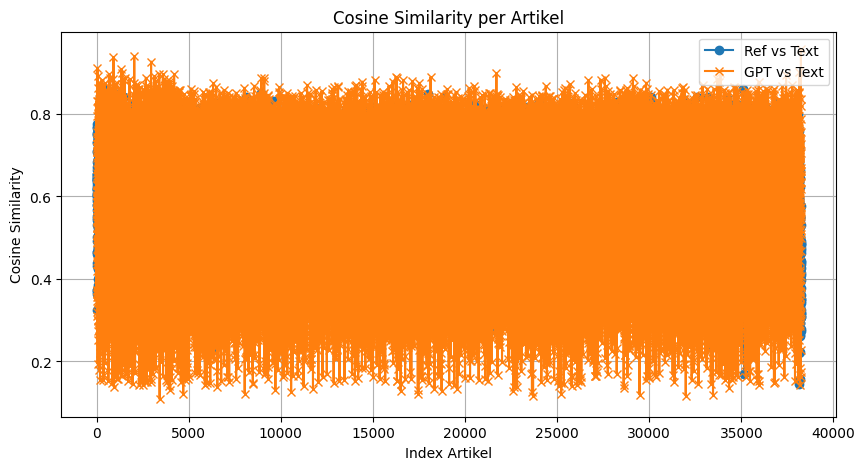

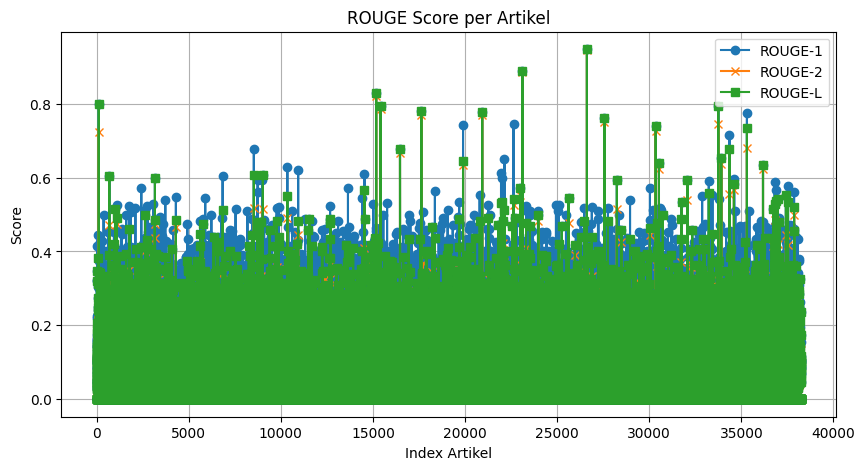

In [17]:
# --- VISUALIZATION ---
plt.figure(figsize=(10,5))
plt.plot(results_df["cosine_ref"], label="Ref vs Text", marker='o')
plt.plot(results_df["cosine_gpt"], label="GPT vs Text", marker='x')
plt.title("Cosine Similarity per Artikel")
plt.xlabel("Index Artikel")
plt.ylabel("Cosine Similarity")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(results_df["rouge1"], label="ROUGE-1", marker='o')
plt.plot(results_df["rouge2"], label="ROUGE-2", marker='x')
plt.plot(results_df["rougeL"], label="ROUGE-L", marker='s')
plt.title("ROUGE Score per Artikel")
plt.xlabel("Index Artikel")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.show()

In [19]:

# --- AMBIGUITY DETECTION ---
threshold = 0.15
results_df["ambiguity_flag"] = abs(results_df["cosine_ref"] - results_df["cosine_gpt"]) > threshold

# --- DISPLAY AMBIGUOUS EXAMPLES ---
for i, row in results_df[results_df["ambiguity_flag"]].head(3).iterrows():
    print(f"\n--- Index: {row['index']} ---")
    print(f"Cosine Ref: {row['cosine_ref']:.3f} | Cosine GPT: {row['cosine_gpt']:.3f}")
    print("Referensi Ringkasan:\n", row["ref_summary"])
    print("Ringkasan GPT:\n", row["gpt_summary"])


--- Index: 0 ---
Cosine Ref: 0.754 | Cosine GPT: 0.489
Referensi Ringkasan:
 Seekor gajah mendadak mengamuk saat prosesi tahunan agama Buddha di Kolombo, Sri Lanka, sehingga membuat peserta upacara tunggang-langgang. Setidaknya 17 orang terluka.
Ringkasan GPT:
 Sri Lanka, memiliki gajah adalah simbol status, memiliki gajah untuk memiliki gajah untuk memiliki gajah untuk memiliki gajah untuk memiliki gajah untuk memiliki gajah untuk memiliki gajah untuk memiliki gajah untuk memiliki gajah untuk

--- Index: 6 ---
Cosine Ref: 0.553 | Cosine GPT: 0.365
Referensi Ringkasan:
 Pada tahun 1931, seorang politisi Inggris yang kemudian menjadi perdana menteri, Winston Churchill memperkirakan bahwa suatu hari manusia dapat "melepaskan diri dari hal mustahil memelihara seekor ayam hanya untuk memakan sayap atau dadanya, dengan cara membiakkan bagian-bagian ini secara terpisah dengan cara yang cocok".
Ringkasan GPT:
 Peternahan di sebuah reaktor biokecil, dan berkeliaran di sebuah peternahan di seb